# TMDB Analysis
<img src="video-camera-icon.png" width="60px" alt="Movie Logo" /> 
<br /><br />
<font size="5em"><i>Alistair Boyer</i></font>

Data source: 'TMDB_movies.csv' from [https://www.themoviedb.org/](https://www.themoviedb.org/)

<hr />

## Setup and Imports

<br />

In [1]:
# data imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# file imports
import pathlib

FILE_LOCATION = pathlib.Path('')

In [3]:
# other imports
import json
import random
import requests

# uncomment to install packages
# pip install pycountry
# pip install iso639-lang
# pip install cpi

# https://pypi.org/project/pycountry/
import pycountry

# https://pypi.org/project/iso639-lang/
import iso639

# https://pypi.org/project/cpi/
import cpi

In [4]:
# preferences
STR_AGGREGATOR = '|'.join
sns.set_color_codes('dark')

<hr />

## Load

<br />

In [5]:
# load dataset
df = pd.read_csv(
    FILE_LOCATION/'TMDB_movies.csv',
)
df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


popularity = e.g. number of votes, favourites, etc... https://developer.themoviedb.org/docs/popularity-and-trending

### Datatype Conversion

In [6]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
dtype: object

#### observations

  - `budget`, `revenue`, `vote_count` are ints [found by read_csv]
  - `popularity`, `runtime`, `vote_average` are floats [found by read_csv]
  - `id` is an int [found by read_csv] and appears to be the data index
  - `release_date` is a date
  - `original_language`, `status` are categorical
  - `original_title`, `overview`, `tagline`, `title` are str
  - `homepage` is a str URL
  - `genres`, `keywords`, `production_countries`, `spoken_languages`, `production_companies` contains json data
  
  
  

#### index

In [7]:
# check that the 'id' is still in the dataset and not already an index
if 'id' in df.columns:

  # check that there are no nulls
  print('Any null id values:', df['id'].isnull().any())
  # no nulls

  # check that the ids are all unique
  print('Unique id count vs dataframe length:', df['id'].nunique(), df.shape[0])
  # all unique

  # use supplied index
  df.set_index('id', inplace=True)

  #rename the index
  df.index.name = 'filmid'

print('dataframe index name:', df.index.name)

Any null id values: False
Unique id count vs dataframe length: 4803 4803
dataframe index name: filmid


#### datetime

In [8]:
# check date conversion

#random.sample(list(df.index), 5)
_eyeball_ids = [2637, 9470, 19933, 335874, 11172]

df.join(
    pd.to_datetime(df['release_date']),
    rsuffix='_to_datetime'
).loc[_eyeball_ids, ['release_date', 'release_date_to_datetime']]
# eyeball check = OK

,release_date,release_date_to_datetime
filmid,,
2637,2002-01-25,2002-01-25
9470,2004-02-10,2004-02-10
19933,1987-07-09,1987-07-09
335874,2015-04-03,2015-04-03
11172,2007-02-09,2007-02-09


In [9]:
# make change
df['release_date'] = pd.to_datetime(df['release_date'])
df[['release_date']].dtypes

release_date    datetime64[ns]
dtype: object

#### category

In [10]:
# check content
print('status:')
print(df['status'].unique())
print()

print('original_language:')
print(df['original_language'].unique())
print()

status:
['Released' 'Post Production' 'Rumored']

original_language:
['en' 'ja' 'fr' 'zh' 'es' 'de' 'hi' 'ru' 'ko' 'te' 'cn' 'it' 'nl' 'ta'
 'sv' 'th' 'da' 'xx' 'hu' 'cs' 'pt' 'is' 'tr' 'nb' 'af' 'pl' 'he' 'ar'
 'vi' 'ky' 'id' 'ro' 'fa' 'no' 'sl' 'ps' 'el']



In [11]:
# make change
df = df.astype(
    {
        'original_language': 'category',
        'status': 'category'
    }
)
print('status:')
print(repr(df['status'].dtype))
print()

print('original_language:')
print(repr(df['original_language'].dtype))

status:
CategoricalDtype(categories=['Post Production', 'Released', 'Rumored'], ordered=False)

original_language:
CategoricalDtype(categories=['af', 'ar', 'cn', 'cs', 'da', 'de', 'el', 'en', 'es', 'fa',
                  'fr', 'he', 'hi', 'hu', 'id', 'is', 'it', 'ja', 'ko', 'ky',
                  'nb', 'nl', 'no', 'pl', 'ps', 'pt', 'ro', 'ru', 'sl', 'sv',
                  'ta', 'te', 'th', 'tr', 'vi', 'xx', 'zh'],
, ordered=False)


#### review of datatypes

In [12]:
df.dtypes

budget                           int64
genres                          object
homepage                        object
keywords                        object
original_language             category
original_title                  object
overview                        object
popularity                     float64
production_companies            object
production_countries            object
release_date            datetime64[ns]
revenue                          int64
runtime                        float64
spoken_languages                object
status                        category
tagline                         object
title                           object
vote_average                   float64
vote_count                       int64
dtype: object

### Nested json Data

Columns with nested data:
`genres`, `keywords`, `production_countries`, `production_companies`, `spoken_languages`

Strategy: extract to separate dataframes and use filmid as index

In [13]:
# create a function to process the cols
def json_extract(df, column_label):

    # parse the json data and explode into rows
    col_exploded = pd.DataFrame(
        df[column_label].apply(lambda x: json.loads(x)).explode()
    )

    # retreive the filmid index
    col_exploded.reset_index(inplace=True)

    # convert json to series
    df = pd.json_normalize(col_exploded[column_label])\
      .join(col_exploded['filmid']) # and join to collect the filmid index

    # reset the filmid index
    df.set_index('filmid', inplace=True)

    return df

# use the explode method to get multi index result
# https://stackoverflow.com/questions/53218931/how-to-unnest-explode-a-column-in-a-pandas-dataframe-into-multiple-rows

In [14]:
# extract the dataframes
df_genres = json_extract(df, 'genres')
df_keywords = json_extract(df, 'keywords')
df_production_countries = json_extract(df, 'production_countries')
df_production_companies = json_extract(df, 'production_companies')
df_spoken_languages = json_extract(df, 'spoken_languages')

<hr />

## Validation and Transform

<br />

### Nested json Data

#### genres

In [15]:
# drop nulls
df_genres.dropna(inplace=True)

# more descriptive label
df_genres.rename(columns={
    'name': 'genre',
    'id': 'genre_id',
}, inplace=True)

# recast ids as int now that nulls have gone
df_genres['genre_id'] = df_genres['genre_id'].astype(int)

# order by genre
df_genres.sort_values('genre', inplace=True)

# check values
df_genres.drop_duplicates().reset_index(drop=True)

# all look ok!

,genre_id,genre
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,10769,Foreign


In [16]:
# generate quick index for lookup by str aggregation
df['genres'] = df_genres.groupby('filmid')['genre'].agg(STR_AGGREGATOR) # '|'.join
# add a helper count column
df['genre_count'] = df_genres.groupby('filmid')['genre'].count()
# fill nulls in count column with 0
df['genre_count'].fillna(0, inplace=True)

#### keywords

In [17]:
# drop nulls
df_keywords.dropna(inplace=True)

# more descriptive label
df_keywords.rename(columns={
    'name': 'keyword',
    'id': 'keyword_id',
}, inplace=True)

# recast ids as int now that nulls have gone
df_keywords['keyword_id'] = df_keywords['keyword_id'].astype(int)

print(df_keywords['keyword'].unique().tolist()[:50])  # nicely wrapped on colab - big mess in jupyter so use :50
# seem ok!

# generate quick index for lookup
df['keywords'] = df_keywords.groupby('filmid')['keyword'].agg(STR_AGGREGATOR)

['culture clash', 'future', 'space war', 'space colony', 'society', 'space travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien planet', 'cgi', 'marine', 'soldier', 'battle', 'love affair', 'anti war', 'power relations', 'mind and soul', '3d', 'ocean', 'drug abuse', 'exotic island', 'east india trading company', "love of one's life", 'traitor', 'shipwreck', 'strong woman', 'ship', 'alliance', 'calypso', 'afterlife', 'fighter', 'pirate', 'swashbuckler', 'aftercreditsstinger', 'spy', 'based on novel', 'secret agent', 'sequel', 'mi6', 'british secret service', 'united kingdom', 'dc comics', 'crime fighter', 'terrorist', 'secret identity', 'burglar', 'hostage drama']


#### production_countries

In [18]:
# load reference values from pycountry
# https://stackoverflow.com/questions/32773035/list-of-language-codes-iso639-1-in-python
df_countries = pd.DataFrame(
    [(country.alpha_2, country.name) for country in pycountry.countries],
    columns=['iso_3166_1', 'country'])
df_countries.set_index('iso_3166_1', inplace=True)

In [19]:
# drop nulls
df_production_countries.dropna(inplace=True)

# more descriptive label
df_production_countries.rename(columns={
    'name': 'country',
    'id': 'country_id',
}, inplace=True)

# get unique
df_unique = df_production_countries.drop_duplicates()

# create a comparison table with pycounty.countries
df_unique = df_unique.join(
    df_countries,
    on='iso_3166_1',
    rsuffix='_check',
)

# find where there is a mismatch
df_unique[df_unique['country'] != df_unique['country_check']]

,iso_3166_1,country,country_check
filmid,,,
19995,US,United States of America,United States
2454,CZ,Czech Republic,Czechia
281957,TW,Taiwan,"Taiwan, Province of China"
11665,RU,Russia,Russian Federation
113464,KR,South Korea,"Korea, Republic of"
26843,LY,Libyan Arab Jamahiriya,Libya
101173,CS,Serbia and Montenegro,NaN
11818,TR,Turkey,Türkiye
68818,BO,Bolivia,"Bolivia, Plurinational State of"


In [20]:
# all are consistent except 'CS'	'Serbia and Montenegro'
# https://en.wikipedia.org/wiki/ISO_3166-1:CS
# depends on date
# check production date
df[df['production_countries'].str.contains('CS')]['release_date']
# film released in 2011 and Serbia and Montenegro valid from 2003 to 2006, assume OK

filmid
101173   2011-02-14
Name: release_date, dtype: datetime64[ns]

In [21]:
# generate quick index for lookup by str aggregation
df['production_countries'] = df_production_countries.groupby('filmid')['iso_3166_1'].agg(STR_AGGREGATOR)
# add helper count column
df['production_countries_count'] = df_production_countries.groupby('filmid')['iso_3166_1'].count()
# set count nuls to zero
df['production_countries_count'].fillna(0, inplace=True)

#### production_companies

In [22]:
# drop nulls
df_production_companies.dropna(inplace=True)

# more descriptive label
df_production_companies.rename(columns={
    'name': 'company',
    'id': 'company_id',
}, inplace=True)

# recast ids as int now that nulls have gone
df_production_companies['company_id'] = df_production_companies['company_id'].astype(int)

# quick look at unique
df_production_companies.drop_duplicates()

,company,company_id
filmid,,
19995,Ingenious Film Partners,289
19995,Twentieth Century Fox Film Corporation,306
19995,Dune Entertainment,444
19995,Lightstorm Entertainment,574
285,Walt Disney Pictures,2
...,...,...
124606,FM Entertainment,26598
124606,Eagle Eye Films Inc.,40739
231617,Front Street Pictures,3958


In [23]:
# drop columns from df
if 'production_companies' in df.columns:
    df.drop(columns=['production_companies'], inplace=True)

# add count column
df['production_companies_count'] = df_production_companies.groupby('filmid')['company_id'].count()
# fill null values in count column with 0
df['production_companies_count'].fillna(0, inplace=True)

#### languages

In [24]:
# load language data from iso639
df_languages = pd.DataFrame(
    [(l.pt1, l.name) for l in iso639.iter_langs() if l.pt1],
    columns=['iso_639_1', 'language'],
)
df_languages.set_index('iso_639_1', inplace=True)

In [25]:
# drop nulls
df_spoken_languages.dropna(inplace=True)

# more descriptive label
df_spoken_languages.rename(columns={
    'name': 'language',
}, inplace=True)

# get unique
df_spoken_languages.drop_duplicates()
# label suggests:
# https://en.wikipedia.org/wiki/ISO_639-2
# appears to be omissions and errors

,iso_639_1,language
filmid,,
19995,en,English
19995,es,Español
206647,fr,Français
206647,it,Italiano
206647,de,Deutsch
...,...,...
37232,dz,
295914,ky,??????
94329,id,Bahasa indonesia


In [26]:
# language has ??? in - replace with ''
df_spoken_languages[df_spoken_languages['language'].str.contains('?', regex=False)] = ''

# create a comparison table with pycounty.countries
if 'language_check' not in df_spoken_languages.columns:
  df_spoken_languages = df_spoken_languages.join(df_languages, on='iso_639_1', rsuffix='_check')

# get lookup value form helper column
df_spoken_languages['language'].fillna(df_spoken_languages['language_check'], inplace=True)

# drop helper column
if 'language_check' in df_spoken_languages.columns:
    df_spoken_languages.drop(columns=['language_check'], inplace=True)



# generate quick index for lookup by str aggregation
df['spoken_languages'] = df_spoken_languages.groupby('filmid')['iso_639_1'].agg(STR_AGGREGATOR)
# add helper count column
df['spoken_languages_count'] = df_spoken_languages.groupby('filmid')['iso_639_1'].count()
# set count nuls to zero
df['spoken_languages_count'].fillna(0, inplace=True)

### Zero Values

In [27]:
# 1576 instances of zero values that would be better represented as np.NaN
df[(df[['revenue', 'runtime', 'popularity', 'vote_average', 'budget']]==0).any(axis=1)].shape[0]

1576

In [28]:
# np.NaN is a float so recast all ints to floats
df[['revenue', 'budget']] = df[['revenue', 'budget']].astype('float')

# change all zero to null
for label in ['revenue', 'runtime', 'popularity', 'vote_average', 'budget']:
    df[label] = df[label].where(df[label]!=0, np.NaN)

### Nulls

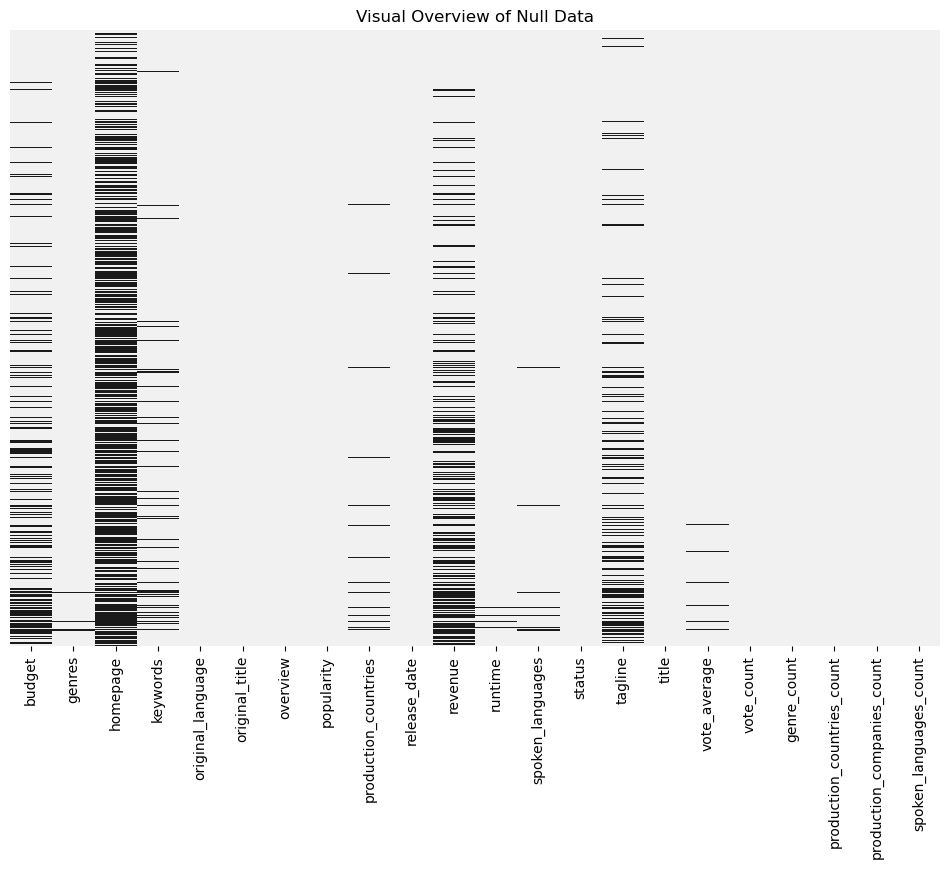

In [29]:
# null info
#df.info()

# visualise null data
plt.figure(
    figsize=(12,8)
)
sns.heatmap(
    df.isnull(),
    cbar=False,
    cmap=sns.color_palette('light:k', as_cmap=True),
)
plt.title('Visual Overview of Null Data')
plt.yticks([])
plt.ylabel('')
plt.show()

In [30]:
# single entry with no date
df[df['release_date'].isnull()]
# also has no other data # DROP
df = df.dropna(subset=['release_date'])

### Website

In [31]:
try:
    with open(FILE_LOCATION/'TMDB_URL_STATUS_CACHE.json', 'r') as f:
        URL_CACHE = json.load(f)


    def website_status(url):
        global URL_CACHE
        if not url:
            return np.NaN
        cached = URL_CACHE.get(url, None)
        if cached is not None:
            return cached
        try:
            status_code = requests.get(
                url,
                timeout=0.3,
            ).status_code
        except Exception:
            status_code = 410
        URL_CACHE[url] = status_code
        return status_code

    df.loc[:,'homepage_status'] = df['homepage'][df['homepage'].notnull()].apply(website_status)

    with open(FILE_LOCATION/'TMDB_URL_STATUS_CACHE.json', 'w') as f:
        json.dump(URL_CACHE, f)

    print(df['homepage_status'])

except FileNotFoundError as e:
    print(e)

filmid
19995     410.0
285       200.0
206647    410.0
49026     200.0
49529     200.0
          ...  
9367        NaN
72766       NaN
231617    410.0
126186    403.0
25975       NaN
Name: homepage_status, Length: 4802, dtype: float64


Roughly equal numbers of websites still exist [200] or have gone away* [410].

In [32]:
# wont run if homepage_status has not been calculated
if 'homepage_status' in df.columns:
    (100 * df.groupby('homepage_status')[['title']].count() / df['title'].count()).rename(columns={'title': 'percentage'}).style.format('{:.1f}%').format_index('{:.0f}')


### Profit

In [33]:
# revenue - budget
if 'profit' not in df:
    df = df.join(
        pd.DataFrame(df['revenue'] - df['budget'], columns=['profit'])
    )
    df['profit_pc'] = 100.0 * df['profit'] / df['budget']
df['profit_pc'] = df.where(df['profit_pc']!=np.inf, np.NaN)['profit_pc']

df['profit']

filmid
19995     2.550965e+09
285       6.610000e+08
206647    6.356746e+08
49026     8.349391e+08
49529     2.413910e+07
              ...     
9367      1.820920e+06
72766              NaN
231617             NaN
126186             NaN
25975              NaN
Name: profit, Length: 4802, dtype: float64

<hr />

## Exploration

<br />

### Extremes

Data spans 100 years of film

In [34]:
#df.describe(include='all', datetime_is_numeric=True)
#TMI see below

In [35]:
for label in [
# production
    'release_date',
    'production_companies_count',
    'production_countries_count',
    'runtime',
# financials
    'profit',
    'budget',
    'revenue',
# vote
    'vote_count',
    'vote_average',
]:
    print('#' * 80)
    print(label, 'min max')
    print(df.dropna(subset=[label]).sort_values(label)[['title', label]].iloc[[0,-1]])
    print()


################################################################################
release_date min max
                   title release_date
filmid                               
3059         Intolerance   1916-09-04
426469  Growing Up Smith   2017-02-03

################################################################################
production_companies_count min max
                     title  production_companies_count
filmid                                                
35944          Lucky Break                         0.0
16      Dancer in the Dark                        26.0

################################################################################
production_countries_count min max
                     title  production_countries_count
filmid                                                
146269  The Young Unknowns                         0.0
16      Dancer in the Dark                        12.0

#######################################################################

### Pearson Correlation

In [36]:
# Pearson correlation to 2 D.P.
# stop at 'spoken_languages_count' because the others are helper agg columns
corr = df.loc[:, :'spoken_languages_count'].corr(numeric_only=True).round(3)
corr

,budget,popularity,revenue,runtime,vote_average,vote_count,genre_count,production_countries_count,production_companies_count,spoken_languages_count
budget,1.000,0.455,0.705,0.255,0.004,0.556,0.260,0.085,0.172,0.091
popularity,0.455,1.000,0.606,0.222,0.283,0.778,0.155,0.085,0.191,0.070
revenue,0.705,0.606,1.000,0.234,0.181,0.758,0.171,0.020,0.071,0.070
runtime,0.255,0.222,0.234,1.000,0.362,0.277,0.061,0.128,0.134,0.201
vote_average,0.004,0.283,0.181,0.362,1.000,0.341,0.014,0.079,0.102,0.106
vote_count,0.556,0.778,0.758,0.277,0.341,1.000,0.154,0.072,0.181,0.096
genre_count,0.260,0.155,0.171,0.061,0.014,0.154,1.000,0.100,0.093,0.115
production_countries_count,0.085,0.085,0.020,0.128,0.079,0.072,0.100,1.000,0.470,0.218
production_companies_count,0.172,0.191,0.071,0.134,0.102,0.181,0.093,0.470,1.000,0.157
spoken_languages_count,0.091,0.070,0.070,0.201,0.106,0.096,0.115,0.218,0.157,1.000


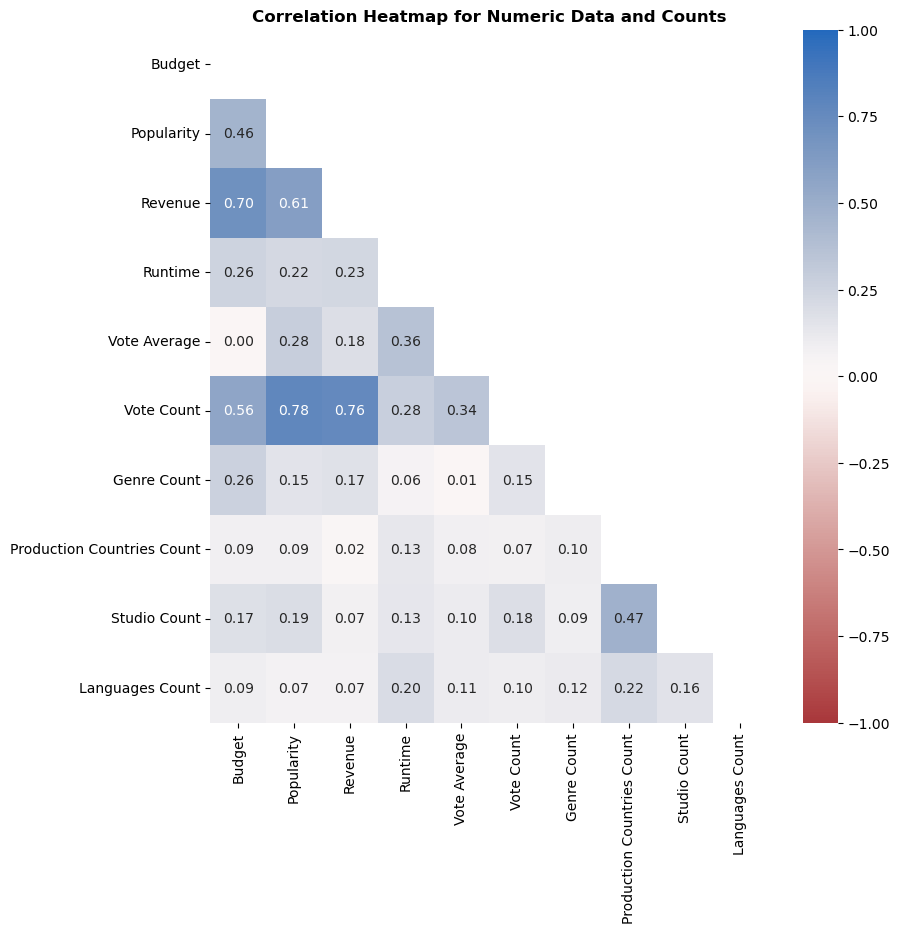

In [37]:
# init plot
plt.figure(
    figsize=(9,9),
)

# plot
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='vlag_r',
    mask=np.triu(np.ones(corr.shape)),
    vmin=-1,
    vmax=1,
)

# formatting
plt.title(
    'Correlation Heatmap for Numeric Data and Counts',
    fontweight='bold',
)

labels = [
        c.replace('production_companies', 'studio').replace('spoken_', '').replace('_', ' ').title()
        for c in corr.columns
]

plt.xticks(
    ticks=[x + 0.5 for x in range(corr.shape[1])],
    labels=labels,
)
plt.yticks(
    ticks=[x + 0.5 for x in range(corr.shape[1])],
    labels=labels,
)
plt.show()

### Time

In [38]:
# function to apply cpi inflation adjustment to a row
def cpi_adjust(row):
    for label in ('revenue', 'budget'):
        row[f'{label}_adjusted'] = cpi.inflate(row[label], int(row['release_date']))
    return row

# argument on forum about inflation adjusted or not
# https://www.themoviedb.org/talk/5b161152c3a3685330016839

In [39]:
# revenue by year

# get copy of revenue data
year_financials = df[['release_date', 'revenue', 'budget']].copy()
# scale value by a million for display
year_financials[['revenue', 'budget']] /= 1e6
# convert date to year
year_financials['release_date'] = year_financials['release_date'].dt.year
# drop nulls
year_financials.dropna(inplace=True)
# calculate inflation adjusted values
year_financials = year_financials.apply(
    cpi_adjust,
    axis=1
)
# set index to date
year_financials.set_index('release_date', inplace=True)
# sort in index
year_financials.sort_index(inplace=True)

# artefact data before 1950
year_financials = year_financials[year_financials.index >= 1950]

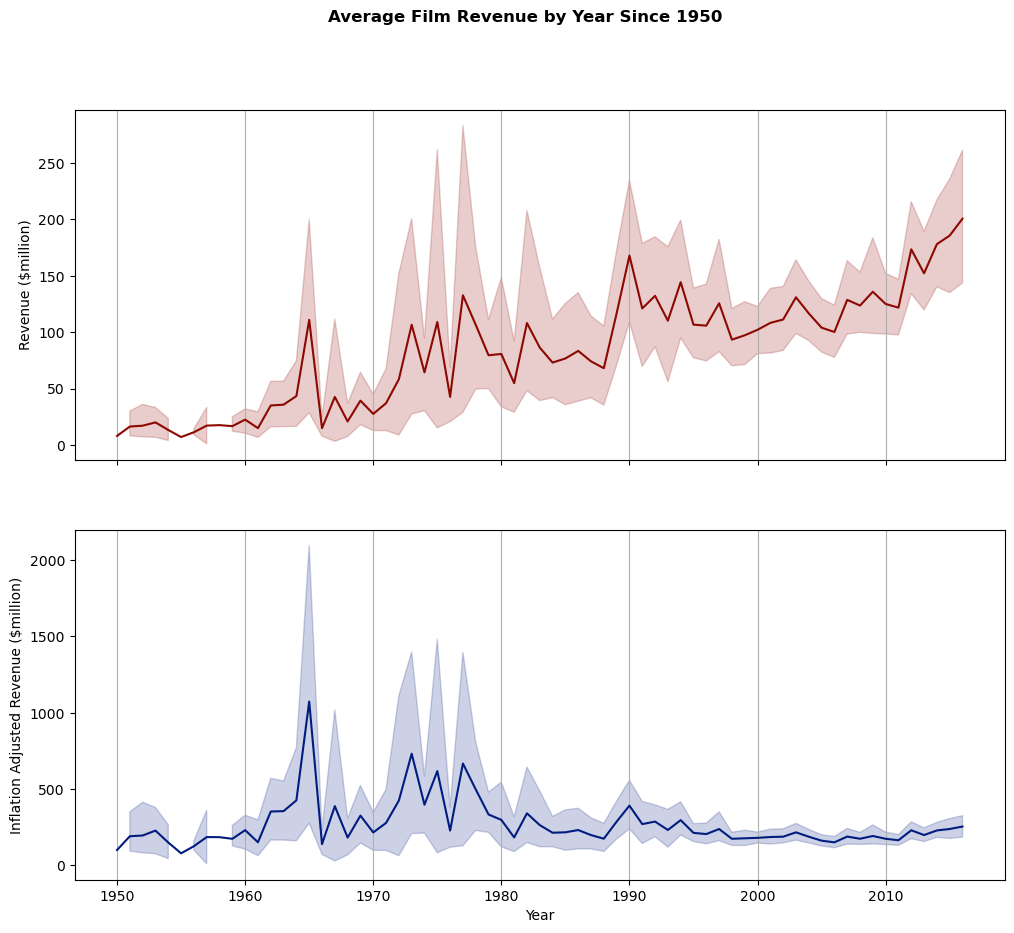

In [40]:
# init plot
fig, axs = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(12,10),
)

# plot
sns.lineplot(
    data=year_financials,
    x=year_financials.index,
    y=year_financials['revenue'],
    color='r',
    ax=axs[0],
)

sns.lineplot(
    data=year_financials,
    x=year_financials.index,
    y=year_financials['revenue_adjusted'],
    color='b',
    ax=axs[1],
)

# labels
fig.suptitle(
    'Average Film Revenue by Year Since 1950',
    fontweight='bold',
)
axs[0].xaxis.grid(True)
axs[1].xaxis.grid(True)
axs[0].set_ylabel('Revenue ($million)')
axs[1].set_ylabel('Inflation Adjusted Revenue ($million)')
plt.xlabel('Year')
plt.show()

### Language

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


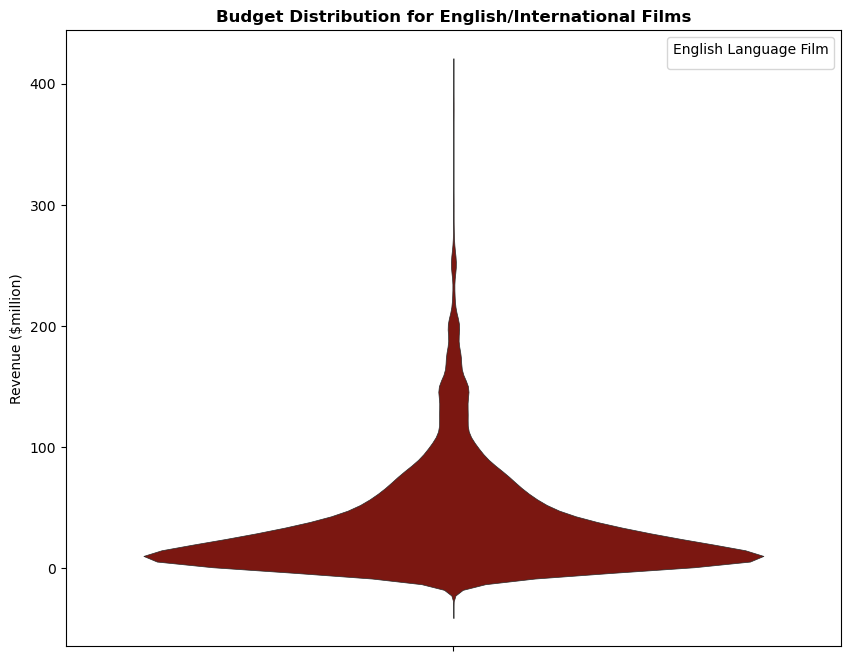

In [41]:
fig, ax = plt.subplots(
    figsize=(10, 8),
)
ax = sns.violinplot(
    y=df['budget']/1e6,
    data=df,
    inner=None,
    hue=df['original_language']=='en',
    density_norm='width',
# styling and layout
    palette=['r', 'b'],
    split=True,
    orient='v',
    gap=.01,
    linewidth=0.5,
    cut=5,
)
ax.set_ylabel('Revenue ($million)')
plt.title(
    'Budget Distribution for English/International Films',
    fontweight='bold',
)
ax.legend(
    title='English Language Film'
)

plt.show()

### Genre

In [42]:
# join with genres dataframe
genre_data = df.join(
    df_genres,
    how='right',
)

In [43]:
# financial data by genre

# group by genre
by_genre = genre_data[['budget', 'revenue', 'vote_average', 'vote_count', 'title', 'genre']].dropna().groupby('genre').agg({
    'budget': 'mean',
    'revenue': 'mean',
    'vote_average': 'mean',
    'vote_count': 'sum',
    'title': 'count',
})
# convert fininace data to millions
by_genre[['budget', 'revenue']] /= 1e6

##### sorting
# all TV movies have NaN revenue, so set to 0 then back to NaN
by_genre.loc['TV Movie', 'revenue'] = 0
by_genre.sort_values(['revenue', 'budget'], ascending=[False, False], inplace=True)
by_genre.loc['TV Movie', 'revenue'] = np.NaN


In [44]:
def gen_plot(df, title, title0, title1):
    #init
    fig, ax = plt.subplots(
        1, 2,
        sharey=True,
        figsize=(16, 8),
    )

    # plot 0 financials
    sns.barplot(
        y=df.index,
        x='revenue',
        data=df,
        label='Revenue',
        color='r',
        ax=ax[0],
        #orient='y',
    )
    sns.barplot(
        y=df.index,
        x='budget',
        data=df,
        label='Budget',
        color='b',
        ax=ax[0],
        #orient='y',
    )
    ax[0].set(
        title=title0,
        xlabel='$million',
        ylabel=None,
    )
    ax[0].legend(
        loc='lower right',
    )


    # plot 1 rating
    sns.scatterplot(
        y=df.index,
        x='vote_average',
        data=df,
        size='vote_count',
        color='g',
        ax=ax[1],
    )
    ax[1].set(
        title=title1,
        xlabel='Vote Average',
    )
    ax[1].legend(
        title='Total Vote Count',
    )

    plt.suptitle(
        title,
        fontweight='bold',
    )

    plt.show()

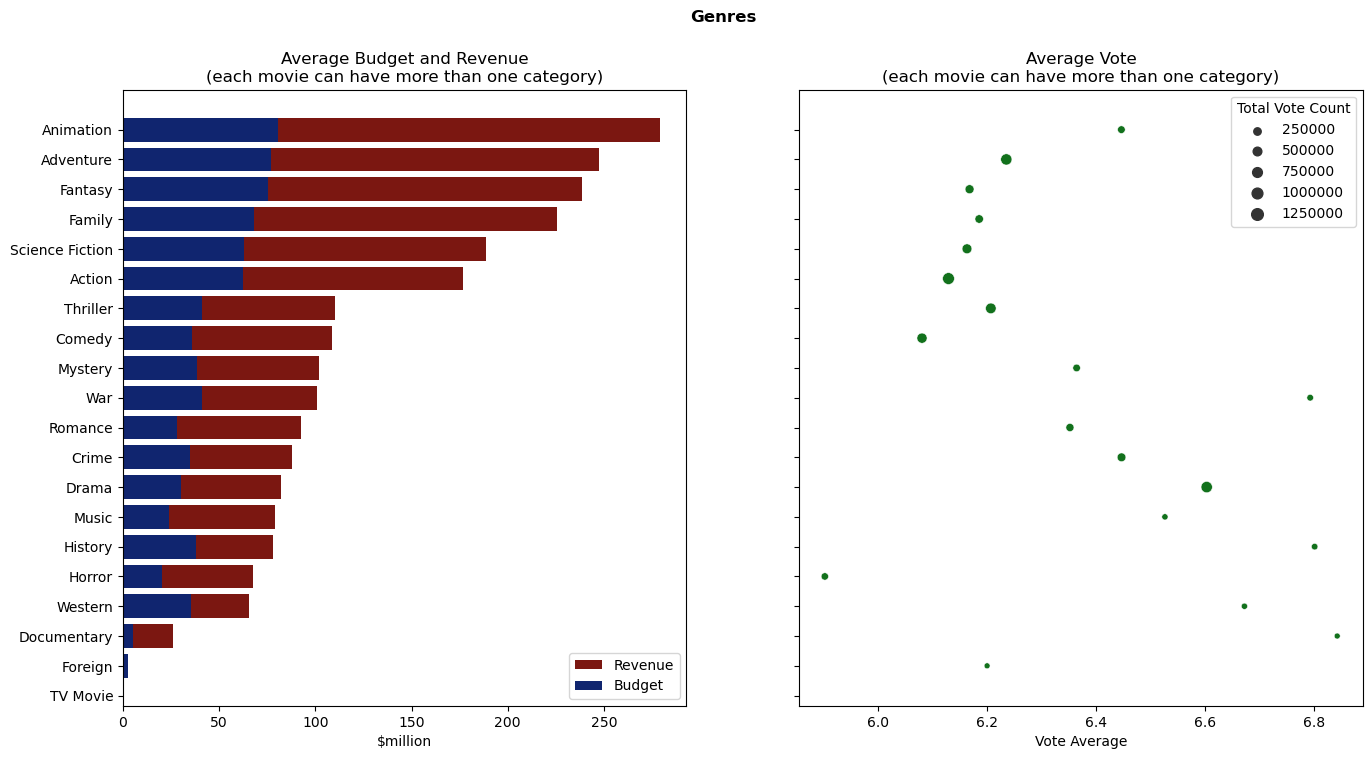

In [45]:
gen_plot(
    by_genre,
    'Genres',
    'Average Budget and Revenue\n(each movie can have more than one category)',
    'Average Vote\n(each movie can have more than one category)',
)

### Studio

In [46]:
# by studio

# join with genres dataframe
by_studio = df.join(
    df_production_companies,
    how='right',
)

# group by genre
by_studio = by_studio[['budget', 'revenue', 'vote_average', 'vote_count', 'title', 'company']].dropna().groupby('company').agg({
    'budget': 'sum',
    'revenue': 'sum',
    'vote_average': 'mean',
    'vote_count': 'sum',
    'title': 'count',
})
# convert fininace data to millions
by_studio[['budget', 'revenue']] /= 1e9

# sort
by_studio.sort_values(['budget'], ascending=[False], inplace=True)

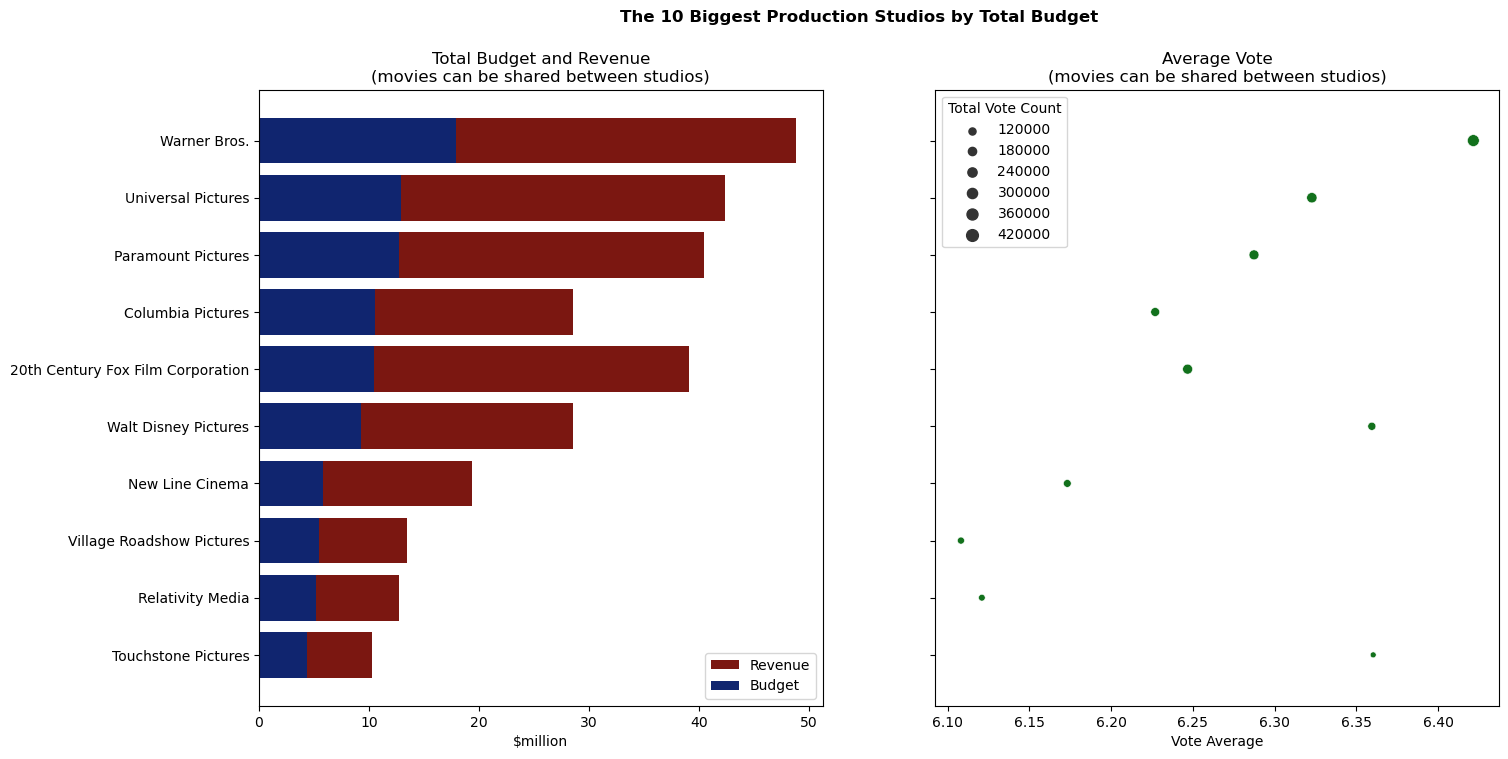

In [47]:
# studio name is a bit long
by_studio.index = by_studio.index.str.replace('Twentieth', '20th')

gen_plot(
    by_studio.iloc[:10],
    'The 10 Biggest Production Studios by Total Budget',
    'Total Budget and Revenue\n(movies can be shared between studios)',
    'Average Vote\n(movies can be shared between studios)',
)

2444 one film studios - production companies that produced just one film.

In [48]:
one_film_studios = by_studio[by_studio['title']==1].index
one_film_studios.shape

(2444,)

### Keywords

In [49]:
# by keyword

# join with genres dataframe
by_keyword = df.join(
    df_keywords,
    how='right',
)

# group by genre
by_keyword = by_keyword[['budget', 'revenue', 'vote_average', 'vote_count', 'title', 'keyword']].dropna().groupby('keyword').agg({
    'budget': 'sum',
    'revenue': 'sum',
    'vote_average': 'mean',
    'vote_count': 'sum',
    'title': 'count',
})
# convert fininace data to millions
by_keyword[['budget', 'revenue']] /= 1e9

# sort
by_keyword.sort_values(['budget'], ascending=[False], inplace=True)

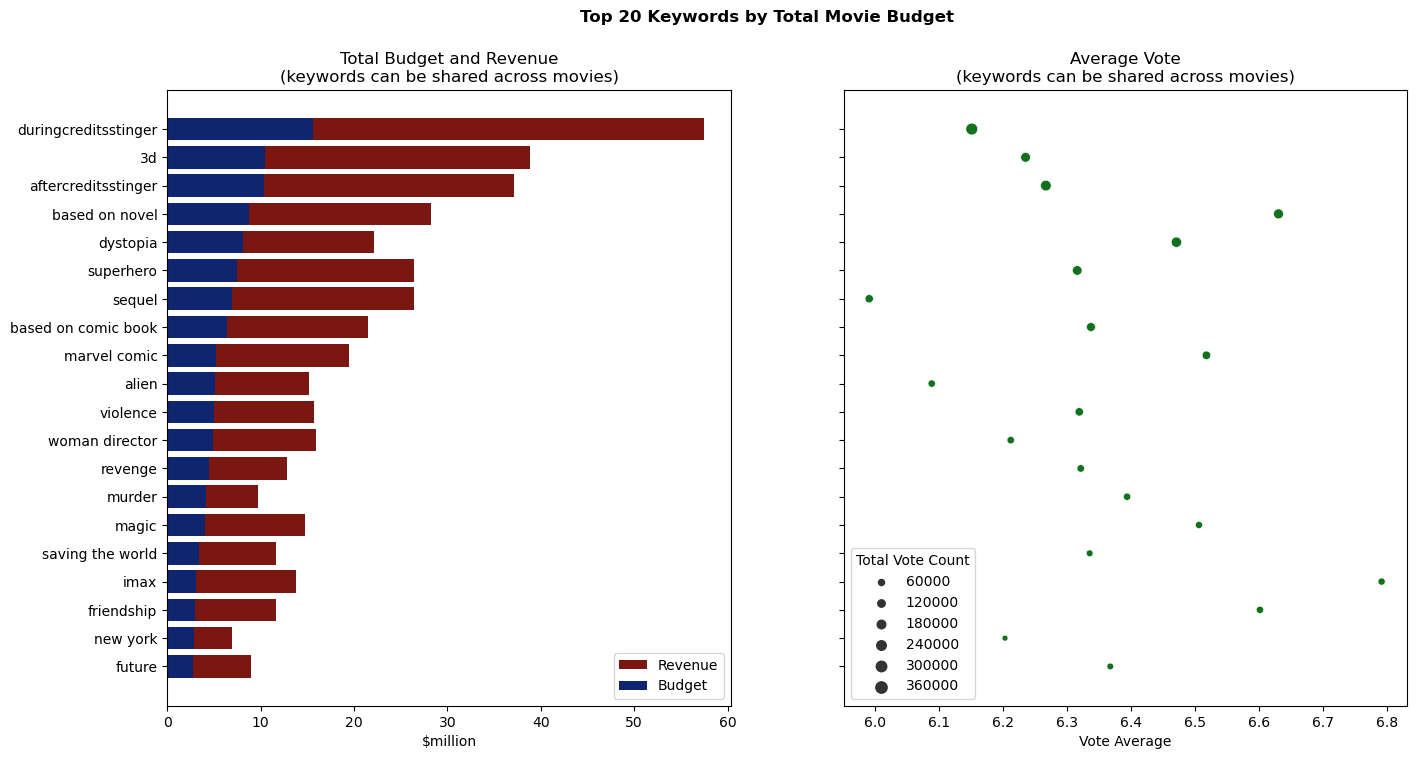

In [50]:
gen_plot(
    by_keyword.iloc[:20],
    "Top 20 Keywords by Total Movie Budget",
    "Total Budget and Revenue\n(keywords can be shared across movies)",
    "Average Vote\n(keywords can be shared across movies)",
)

## Summary of Key Points

  - Revenue in the film industry has grown over time (or has it after CPI adjustment)
  - Money doesn't buy happiness (or at least vote average)

<hr />

# "The Matrix" _vs_ <br /> "Crouching Tiger Hidden Dragon"

_The Cinematic Fight Choreography of Yuen Woo-Ping_


In [51]:
matrix = df[df['title'] == 'The Matrix'] # 603
tiger = df[df['title'] == 'Crouching Tiger, Hidden Dragon'] # 146

# create loc filter
moi = [matrix.index[0], tiger.index[0]]
moi_df = df.loc[moi]

The Matrix [The Wachowskis]

In [52]:
print(df.loc[matrix.index[0], 'overview'])

Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.


Crouching Tiger, Hidden Dragon	卧虎藏龙	[Ang Lee]

In [53]:
print(df.loc[tiger.index[0], 'overview'])

Two warriors in pursuit of a stolen sword and a notorious fugitive are led to an impetuous, physically-skilled, teenage nobleman's daughter, who is at a crossroads in her life.


Both films shared an "Action" theme but The Matrix focussed on science fiction;
and Crouching Tiger, Hidden Dragon was about Romance, Drama and Adventure.

In [54]:
moi_df[['title', 'genres']]

,title,genres
filmid,,
603,The Matrix,Action|Science Fiction
146,"Crouching Tiger, Hidden Dragon",Action|Adventure|Drama|Romance


Both films were released at the turn of the millenium:

In [55]:
moi_df[['title', 'release_date']]

,title,release_date
filmid,,
603,The Matrix,1999-03-30
146,"Crouching Tiger, Hidden Dragon",2000-10-01


78 weeks apart:

In [56]:
(tiger['release_date'].values[0] - matrix['release_date'].values[0]).astype('timedelta64[W]').astype(str)

'78 weeks'

However, they were released base around different markets:

In [57]:
moi_df[['title', 'original_title', 'original_language']]

,title,original_title,original_language
filmid,,,
603,The Matrix,The Matrix,en
146,"Crouching Tiger, Hidden Dragon",卧虎藏龙,zh


Both movies had substantial budgets but were box office smash hits:

In [58]:
df_displ = df.loc[moi][['title', 'budget', 'revenue', 'profit', 'profit_pc']]
df_displ[['budget', 'revenue', 'profit']] /= 1e6
df_displ.style.format({'budget':'${:.0f}m', 'revenue':'${:.0f}m', 'profit':'${:.0f}m', 'profit_pc':'{:.0f}%'})

,title,budget,revenue,profit,profit_pc
filmid,,,,,
603,The Matrix,$63m,$464m,$401m,636%
146,"Crouching Tiger, Hidden Dragon",$17m,$214m,$197m,1156%


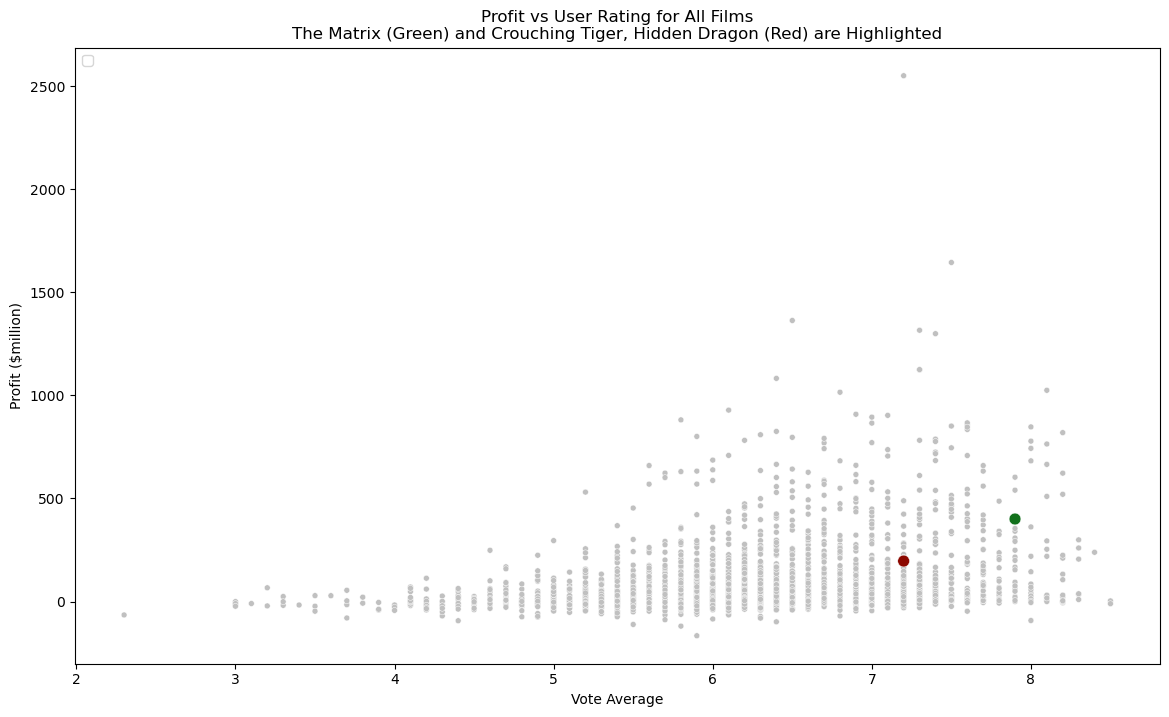

In [59]:
# get a plot data copy
plot_data = df[['vote_average', 'profit', 'title', 'genres']].copy()
plot_data[['profit']] /= 1e6
plot_data.dropna(inplace=True)

# create custom hue mapping
plot_data['hue'] = np.zeros((plot_data.shape[0], 1))

# set matrix
plot_data.loc[matrix.index[0], 'hue'] = 1
# set tiger
plot_data.loc[tiger.index[0], 'hue'] = 2

# sort to get on top
plot_data.sort_values('hue', inplace=True)

#init
fig, ax = plt.subplots(
    1, 1,
    figsize=(14, 8),
)

ax = sns.scatterplot(
    x='vote_average',
    y='profit',
    data=plot_data,
    hue='hue',
    size=(plot_data['hue'] == 0),
    palette=['silver', 'g', 'r'],
)
plt.title('Profit vs User Rating for All Films\nThe Matrix (Green) and Crouching Tiger, Hidden Dragon (Red) are Highlighted')
ax.set_ylabel('Profit ($million)')
ax.set_xlabel('Vote Average')
ax.legend(
    ax.lines[1:],
    ['The Matrix', 'Crouching Tiger, Hidden Dragon'],
    loc='upper left',
)
plt.show()

### Ranking

The two films rank in the top 500 for profit and profit percentage out of all 4800+ movies in the database. \
The Matrix is ranked even higher in public opinion (vote average)  wheras Crouching Tiger, Hidden Dragon does not do as well.

In [60]:
# all movies
print(df.shape[0], 'movies in total.')

# get ranks
profit_pc_rank = df['profit_pc'].dropna().rank(method='min', ascending=False).loc[moi]
profit_rank = df['profit'].dropna().rank(method='min', ascending=False).loc[moi]
vote_average_rank = df['vote_average'].dropna().rank(method='min', ascending=False).loc[moi]

profit_pc_rank.name = 'profit_pc_rank'
profit_rank.name = 'profit_rank'
vote_average_rank.name = 'vote_average_rank'

# join ranks
df.loc[moi][['title']].join(profit_pc_rank).join(profit_rank).join(vote_average_rank).style.format({
    'profit_rank': '{:.0f}',
    'profit_pc_rank':'{:.0f}',
    'vote_average_rank':'{:.0f}',
})

4802 movies in total.


,title,profit_pc_rank,profit_rank,vote_average_rank
filmid,,,,
603,The Matrix,420,148,86
146,"Crouching Tiger, Hidden Dragon",203,383,572


When looking at only the Action movies, both films are also ranked highly. \
The Matrix now breaking into the top 15 all time ranked Acton movies.

In [61]:
# action movies
action = df.loc[df_genres[df_genres['genre']=='Action'].index]
print(action.shape[0], 'action movies in total.')

# get ranks
profit_pc_rank = action['profit_pc'].dropna().rank(method='min', ascending=False).loc[moi]
profit_rank = action['profit'].dropna().rank(method='min', ascending=False).loc[moi]
vote_average_rank = action['vote_average'].dropna().rank(method='min', ascending=False).loc[moi]

profit_pc_rank.name = 'profit_pc_rank'
profit_rank.name = 'profit_rank'
vote_average_rank.name = 'vote_average_rank'

# join ranks
action.loc[moi][['title']].join(profit_pc_rank).join(profit_rank).join(vote_average_rank).style.format({
    'profit_rank': '{:.0f}',
    'profit_pc_rank':'{:.0f}',
    'vote_average_rank':'{:.0f}',
})

1154 action movies in total.


,title,profit_pc_rank,profit_rank,vote_average_rank
filmid,,,,
603,The Matrix,68,76,13
146,"Crouching Tiger, Hidden Dragon",26,167,96


For Crouching Tiger, Hidden Dragon, we can also consider how it ranked within non-english langage films. \
It is the third more profit-generating film of all time but falls down in the user vote.

In [62]:
# non english movies
nonenglish = df[df['original_language']!='en']
print(nonenglish.shape[0], 'non english movies in total.')


# get ranks
profit_pc_rank = nonenglish['profit_pc'].dropna().rank(method='min', ascending=False)
profit_rank = nonenglish['profit'].dropna().rank(method='min', ascending=False)
vote_average_rank = nonenglish['vote_average'].dropna().rank(method='min', ascending=False)

profit_pc_rank.name = 'profit_pc_rank'
profit_rank.name = 'profit_rank'
vote_average_rank.name = 'vote_average_rank'

# join ranks
nonenglish.loc[tiger.index.values][['title']].join(profit_pc_rank).join(profit_rank).join(vote_average_rank).style.format({
    'profit_rank': '{:.0f}',
    'profit_pc_rank':'{:.0f}',
    'vote_average_rank':'{:.0f}',
})

298 non english movies in total.


,title,profit_pc_rank,profit_rank,vote_average_rank
filmid,,,,
146,"Crouching Tiger, Hidden Dragon",11,3,75


Both movies are popular but The Matrix has over double the popularity of Crouching Tiger, Hidden Dragon. \
No doubt, the popularity is boosted by the three sequel movies spanning over 20 years.

The scale of the movies meant multiple production companies were involved:

In [63]:
df.loc[moi].join(df_production_companies)[['title', 'company']].sort_values(['title', 'company'])

,title,company
filmid,,
146,"Crouching Tiger, Hidden Dragon",Asia Union Film & Entertainment Ltd.
146,"Crouching Tiger, Hidden Dragon",China Film Co-Production Corporation
146,"Crouching Tiger, Hidden Dragon",Columbia Pictures Film Production Asia
146,"Crouching Tiger, Hidden Dragon",EDKO Film
146,"Crouching Tiger, Hidden Dragon",Good Machine
146,"Crouching Tiger, Hidden Dragon",Sony Pictures Classics
146,"Crouching Tiger, Hidden Dragon",United China Vision
146,"Crouching Tiger, Hidden Dragon",Zoom Hunt International Productions Company Ltd.
603,The Matrix,Groucho II Film Partnership


The size of companies involved in production varied from the behemoth of Warner Bros. (which has made 319 movies) down to three single picture studios that were only ever involved with Crouching Tiger, Hidden Dragon.

In [64]:
# self join the production companies to find other films
other_films_by_studio = df_production_companies.loc[moi].set_index('company_id').join(
    df_production_companies.reset_index().set_index('company_id'),
    on='company_id',
    rsuffix='_j',
)[['filmid', 'company']].set_index('filmid')

other_films_by_studio[['company']].value_counts()

company                                         
Warner Bros.                                        319
Village Roadshow Pictures                            81
Silver Pictures                                      33
Sony Pictures Classics                               16
Good Machine                                         11
China Film Co-Production Corporation                  7
Columbia Pictures Film Production Asia                2
EDKO Film                                             2
Groucho II Film Partnership                           2
Asia Union Film & Entertainment Ltd.                  1
United China Vision                                   1
Zoom Hunt International Productions Company Ltd.      1
Name: count, dtype: int64

The studios involved have produced 388 different films.

In [65]:
other_films_by_studio.reset_index()['filmid'].nunique()

388